### Линейная регрессия

##### Простая линейная регрессия

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

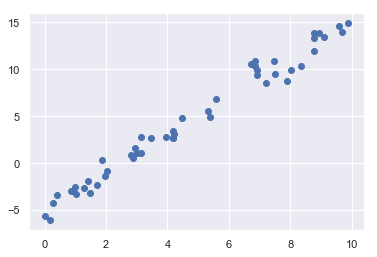

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x -5 + rng.randn(50)
plt.scatter(x,y);

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True) # fit_intercept - центрировать данные (да/нет)
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

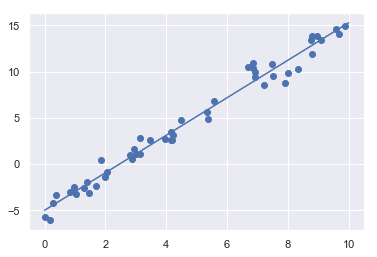

In [4]:
plt.scatter(x,y)
plt.plot(xfit, yfit);

In [5]:
print("Угловой коэффициент модели: ", model.coef_[0])
print("Точка пересечения с осью y: ", model.intercept_)

Угловой коэффициент модели:  2.027208810360695
Точка пересечения с осью y:  -4.998577085553202


In [6]:
model.intercept_

-4.998577085553202

Однако возможности оценивателя LinearRegression намного шире этого: помимо
аппроксимации прямыми линиями, он может также работать с многомерными
линейными моделями

#### Полиномиальные базисные функции (PolynomialFeatures)

In [7]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)# include_bias - If True (default), then include a bias column 11111
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

Как видим, преобразователь превратил наш одномерный массив в трехмерный
путем возведения каждого из значений в степень. Это новое, более многомерное
представление данных можно далее использовать для линейной регрессии.

Как мы уже видели в разделе «Проектирование признаков» данной главы, самый
изящный способ выполнения этого — воспользоваться конвейером. Создадим,
указанным образом полиномиальную модель седьмого порядка:

In [8]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

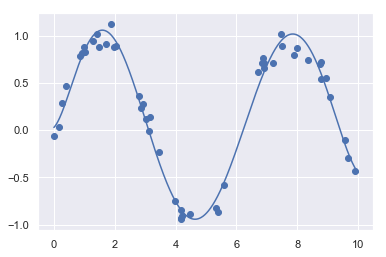

In [9]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x,y)
plt.plot(xfit, yfit);

С нашей линейной моделью, используя полиномиальные базисные функции седьмого порядка, мы получили великолепную аппроксимацию этих нелинейных данных!

### Гауссовы базисные функции

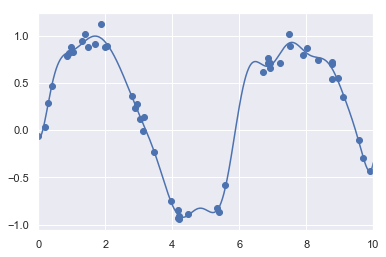

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Равномерно распределенные Гауссовы признаки для одномерных входных данных"""
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg**2, axis))
    def fit(self, X, y=None):
        # Создаем N центров, распределенных по всему диапазону данных
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    def transform(self, X):
        return self._gauss_basis(X[:,:,np.newaxis], 
                                 self.centers_, self.width_, axis=1)
gauss_model = make_pipeline(GaussianFeatures(20), 
                            LinearRegression())
gauss_model.fit(x[:,np.newaxis], y)
yfit = gauss_model.predict(xfit[:,np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

#### Регуляризация

(-1.5, 1.5)

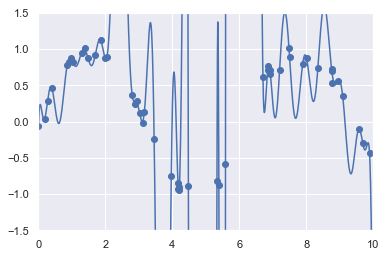

In [26]:
# пример переобучения
model = make_pipeline(GaussianFeatures(40), LinearRegression())
model.fit(x[:,np.newaxis], y)
plt.scatter(x,y)
plt.plot(xfit, model.predict(xfit[:,np.newaxis]))
plt.xlim(0,10)
plt.ylim(-1.5, 1.5)


In [32]:
# напишем функцию, которая строит 
# график коэффициентов Гауссовых базисных функций в соответствии с координатой x
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x,y)
    ax[0].plot(xfit, model.predict(xfit[:,np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel='Базовое местоположение (basis location)', 
              ylabel='Коэффициент (coefficient)', xlim=(0, 10)) 

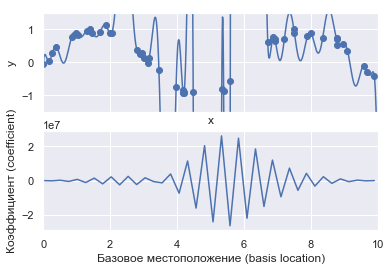

In [33]:
model = make_pipeline(GaussianFeatures(40), LinearRegression())
basis_plot(model)

Регуляризация - штраф модели за высокие коэффициенты

### L2-регуляризация (Гребневая регрессия) - Ridge

Штраф для модели:

$$P =\alpha \sum_{n=1}^N \theta_n ^ 2 $$

где $\theta$ - n-й коэффициент, $\alpha$ - свободный параметр, служащий для управления уровнем штрафа. 

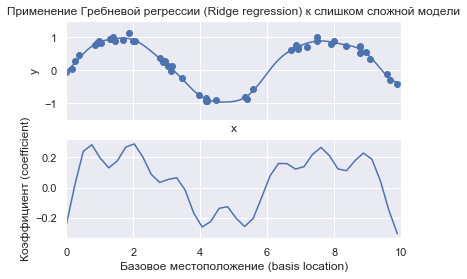

In [52]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(40), Ridge(alpha=0.1)) # установим альфа
basis_plot(model, title="Применение Гребневой регрессии (Ridge regression) к слишком сложной модели")

### Лассо-регуляризация (L1)

штрафование на сумму абсолютных значений (L1-норма) коэффициентов регрессии

$$P =\alpha \sum_{n=1}^N \ |\theta_n| $$

Лассо-регрессия любит разреженные модели, то есть она по возможности делает коэффициенты модели равными нулю

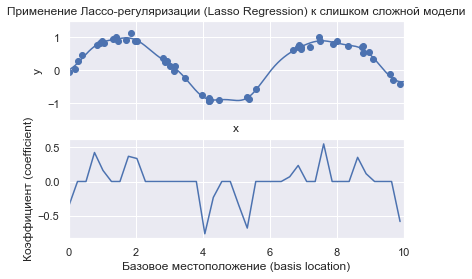

In [59]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(40), Lasso(alpha=0.001)) # установим альфа
basis_plot(model, title="Применение Лассо-регуляризации (Lasso Regression) к слишком сложной модели")

Параметр альфа нужно подбирать перекрестной проверкой

#### Пример: предсказание велосипедного трафика

In [111]:
import pandas as pd
#counts = pd.read_csv('Fremont_Bridge.csv', index_col='Date', parse_dates=True)
#weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [112]:
counts = pd.read_csv('FremontHourly.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('SeaTacWeather.csv', index_col='DATE', parse_dates=True)

In [113]:
counts.head()

,Fremont Bridge NB,Fremont Bridge SB
Date,,
2012-10-02 00:00:00,0.0,0.0
2012-10-02 01:00:00,0.0,0.0
2012-10-02 02:00:00,0.0,0.0
2012-10-02 03:00:00,0.0,0.0
2012-10-02 04:00:00,0.0,0.0


In [114]:
weather.head()

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT14,WT01,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-10-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,233,89,30,40,30,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-10-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,178,100,41,10,20,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-10-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,189,78,73,10,20,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-10-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,189,83,65,20,20,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-10-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,217,89,57,360,360,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999


In [115]:
daily = counts.resample(rule='d', how='sum')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


In [116]:
daily['Total'] = daily.sum(axis=1)

In [117]:
daily = daily[['Total']] # удаляем остальные столбцы

In [118]:
daily.head()

,Total
Date,
2012-10-02,1938.0
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0


In [119]:
# добавим двоичные индикаторы дня недели
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [120]:
daily.head(2)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-02,1938.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [121]:
# добавим двоичные индикаторы выходных и праздников
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

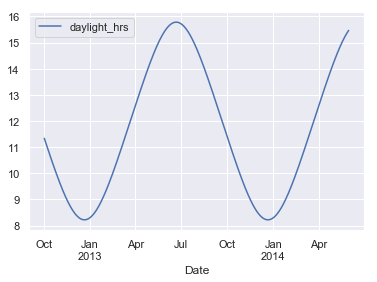

In [122]:
# добавим информацию о естественной освещенности
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Рассчитываем длительность светового дня для заданной даты"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot();

In [123]:
daily.head(2)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs
Date,,,,,,,,,,
2012-10-02,1938.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.335681
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359


In [124]:
# добавим к данным среднюю температуру и общее количество осадков

In [125]:
weather.head(2)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT14,WT01,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-10-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,233,89,30,40,30,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-10-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,178,100,41,10,20,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999


In [126]:
 # Температуры указаны в десятых долях градуса Цельсия;
 # преобразуем в градусы
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = (weather['TMIN'] + weather['TMAX'])/2
weather.head(2)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT01,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03,Temp (C)
DATE,,,,,,,,,,,,,,,,,,,,,
2012-10-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,23.3,8.9,30,40,30,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,16.1
2012-10-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,17.8,10.0,41,10,20,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,13.9


In [127]:
weather.columns

Index(['STATION', 'STATION_NAME', 'PRCP', 'SNWD', 'SNOW', 'TMAX', 'TMIN',
       'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT14', 'WT01', 'WT02', 'WT22',
       'WT04', 'WT13', 'WT16', 'WT08', 'WT18', 'WT03', 'Temp (C)'],
      dtype='object')

In [128]:
# Осадки указаны в десятых долях миллиметра; преобразуем в дюймы
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP']==0).astype(int)

In [129]:
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])


In [130]:
# Добавим счетчик, который будет увеличиваться, начиная с первого дня, и отмерять
# количество прошедших лет. Он позволит нам отслеживать ежегодные увеличения
# или уменьшения ежедневного количества проезжающих:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [131]:
# готово
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-02,1938.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.335681,0.0,13.90,1,0.000000
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1,0.002740
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1,0.005479
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1,0.008219
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1,0.010959


In [132]:
daily.columns

Index(['Total', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'PRCP', 'Temp (C)', 'dry day', 'annual'],
      dtype='object')

In [135]:
# Обучим модели
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']


In [141]:
model = LinearRegression(fit_intercept=False)
model.fit(X,y)
daily['predicted'] = model.predict(X)

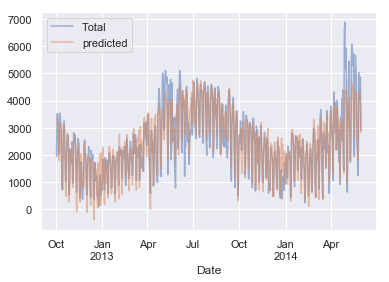

In [142]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [143]:
# посмотрим на коэфиициенты для признаков
params = pd.Series(model.coef_, index = X.columns)
params

Mon              265.779104
Tue              306.551668
Wed              359.247220
Thu              199.486334
Fri              -93.133822
Sat            -1276.752727
Sun            -1308.178141
holiday        -1190.062935
daylight_hrs     137.183312
PRCP            -662.551672
dry day          558.729470
Temp (C)          64.596364
annual           210.767214
dtype: float64

In [145]:
# Эти числа нелегко интерпретировать в отсутствие какой-либо меры их неопределенности
# Быстро вычислить погрешности можно путем бутстрэппинга — повторных выборок данных
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X,y)).coef_ for i in range(1000)], 0)

In [146]:
print(pd.DataFrame({'effect':params.round(0), 'error':err.round(0)}))

              effect  error
Mon            266.0  128.0
Tue            307.0  128.0
Wed            359.0  124.0
Thu            199.0  127.0
Fri            -93.0  115.0
Sat          -1277.0  128.0
Sun          -1308.0  129.0
holiday      -1190.0  196.0
daylight_hrs   137.0   14.0
PRCP          -663.0   70.0
dry day        559.0   44.0
Temp (C)        65.0    5.0
annual         211.0   47.0


In [147]:
#  с каждым дополнительным часом
# светлого времени суток велосипедистов становится больше на 137 ± 14
# рост температуры на 1 градус Цельсия стимулирует 65 ± 5 человек взяться за велосипед
#  каждый дюйм осадков означает, что на 663 ± 70 больше людей оставляют велосипед дома